<a name="top" id="top"></a>

<div align="center">
    <h1>CHE597 - Transfer Learning </h1>
    <a href="https://github.com/bernalde">David E. Bernal Neira</a>
    <br>
    <i>Davidson School of Chemical Engineering, Purdue University</i>
    <br>
    <a href="https://colab.research.google.com/github/SECQUOIA/PU_CHE597_S2025/blob/main/8-Linear_Regression/Linear_Regression.ipynb" target="_parent">
        <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
    </a>
    <a href="https://secquoia.github.io/">
        <img src="https://img.shields.io/badge/🌲⚛️🌐-SECQUOIA-blue" alt="SECQUOIA"/>
    </a>
</div>

# Table of Contents
- [Example Data](#example-data)
  - [Things I'm Leaving Out](#things-im-leaving-out)
  - [Preliminary Imports](#preliminary-imports)
- [Single Task Model](#single-task-model)
- [Difference Model](#difference-model)

In [1]:
# If using this on Google colab, we need to install the packages
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False


<b>If you are using google colab you should save this notebook and any associated textfiles to their own folder on your google drive. Then you will need to adapt the following commands so that the notebook runs from the location of that folder.</b>


In [2]:
# If you want to use Google Drive to save/load files, set this to True
USE_GOOGLE_DRIVE = False
if IN_COLAB and USE_GOOGLE_DRIVE:
    from google.colab import drive
    drive.mount('/content/drive')

    # Colab command to navigate to the folder holding the homework,
    # CHANGE FOR YOUR SPECIFIC FOLDER LOCATION IN GOOGLE DRIVE
    # Note: if there are spaces in the path, you need to preceed them with a backslash '\'
    %cd /content/drive/My\ Drive/APS_Example

## Example Data
For this example I have scraped some data from polymerdatabase.org pertaining to the high-MW Tg of ~200 polymers (`TG_ref`) and the cohesive energy of their repeat units (`Ecoh`). I've also provided Tg predictions from a relatively inaccurate but cheap model (`TG_model`). We will use the low quality Tg predictions as a transfer learning variable in a difference model and compare the results with a model trained only on the experimental Tg data.

To facilitate the example I've also calculated the morgan fingerprint of each polymer's monomer, which we will use as a feature for training our models. Usually you would use a package like RDKit for this, but I've done this for you already so that colab users can run the examples. 

### Things I'm Leaving Out

- This example is somewhat contrived. Our `TG_model` variable is information rich and mainly suffers from a polynomial bias, which can be easily learned (even by less sophisticated models). As covered throughout the presentation, this isn't usually the case, and TL really shines when multiple non-linearly correlated sources of information are employed. 

- Usually hyperparameter optimization with cross-validation would be a routine part of developing any model (including one based on transfer learning concepts). I've performed a crude hyperparameter optimization beforehand, so that in this notebook we will only be training two models and they will quickly execute. I'm emphasizing this so that you don't naively leave out this crucial step in your own experiments. 

- We'll only be comparing random forest based models for the sake of illustrating the transfer learning effect. These models will train extremely fast, but are actually relatively limited in their ability to exhibit strong transfer learning effects compared with neural networks. A reasonable hyperparameter optimization for NN-based models would have taken more time, this is the only reason we won't employ them here. 


### Preliminary Imports
To start we'll import numpy, pandas, and matplotlib for data ingestion and visualization, respectively. We'll be using scikit-learn for training the random forest models. 

In [3]:
# library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

The polymer data we will use is the `training.txt` and the training features are in `training_FP.txt`. `training.txt` contains reference Tg data that I've scraped from polymerdatabase.com under the header `TG_ref` along with the Tg predictions of an emprical model, under the header `TG_model`. Polymer names, SMILES of the monomer units, and cohesive energy densities are there are well for your exploration. 

The corresponding quantities for the testing data are in the `testing*` files. The testing data was obtained as a stratified 10% split of the scraped data, to include at least one representative of each polymer class. 

In the following cell we will import the data with pandas and numpy:

In [4]:
### Import polymer data
train_data = pd.read_csv("training.txt",sep='^') # due to SMILES and polymer names I've used a ^ delimiter for our files
test_data = pd.read_csv("testing.txt",sep='^') # due to SMILES and polymer names I've used a ^ delimiter for our files

### Import fingerprints (these are arrays so we use numpy directly)
train_prints = np.genfromtxt("training_FP.txt")
test_prints = np.genfromtxt('testing_FP.txt')

### Print diagnostics
print("Number of samples in training set: {}".format(len(train_data["Name"])))
print("Number of samples in testing set: {}".format(len(test_data["Name"])))
print("\nPolymer data columns and dtypes:")
for _ in train_data.columns: print("{}: {}".format(_,train_data[_].dtype)) 
print("Example of a Morgan Fingerprint: {}".format(train_prints[0]))

Number of samples in training set: 195
Number of samples in testing set: 20

Polymer data columns and dtypes:
Name: object
SMILES: object
TG_ref: float64
TG_model: float64
Ecoh: float64
Example of a Morgan Fingerprint: [1. 0. 1. ... 0. 0. 0.]


Let's take a brief look at the training data that we will be utilizing via a `TG_ref` vs `TG_model` parity plot and `TG_ref` histogram:

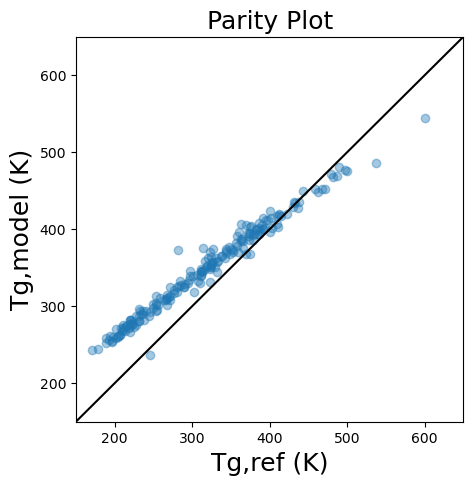

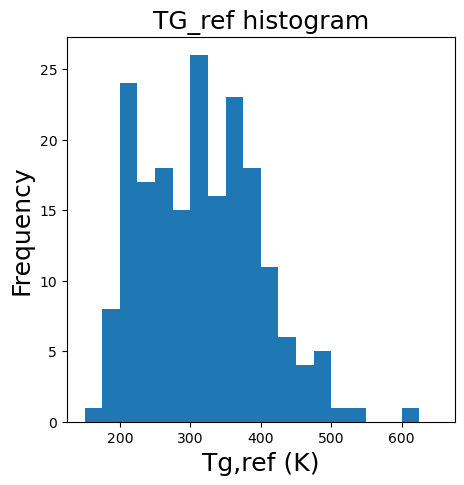

Mean |Tg-Tg,model| (AE):    33.63
Mean %AE:   12.77
StdAE:      19.54
Median AE:  30.43


In [5]:
# Parity plot of ref vs model Tg in training dataa
plt.figure(figsize=(5,5))
plt.plot([150,650],[150,650],color="k")
plt.scatter(train_data["TG_ref"],train_data["TG_model"],alpha=0.4)
plt.xlim(150,650)
plt.ylim(150,650)
plt.xlabel("Tg,ref (K)",size=18)
plt.ylabel("Tg,model (K)",size=18)
plt.title("Parity Plot",size=18)

# Histogram of training data
plt.figure(figsize=(5,5))
plt.hist(train_data["TG_ref"],bins=np.arange(150,655,25))
plt.xlabel("Tg,ref (K)",size=18)
plt.ylabel("Frequency",size=18)
plt.title("TG_ref histogram",size=18)
plt.show()

# Compute and print summary statistics for TG_model compared with TG_ref
ae = np.absolute(test_data["TG_model"]-test_data["TG_ref"])
print('Mean |Tg-Tg,model| (AE):   {:< 4.2f}'.format(np.mean(ae)))
print('Mean %AE:  {:< 4.2f}'.format(np.mean(ae/test_data["TG_ref"]*100.0)))
print('StdAE:     {:< 4.2f}'.format(np.std(ae)))
print('Median AE: {:< 4.2f}'.format(np.median(ae)))

Based on the parity plot and summary statistics you can tell that `TG_model` carries information relevant to `TG_ref`, although it suffers from a systematic bias and a non-linear deviation, especially for high Tg materials.

### Single Task Model
As a baseline we will train random forest model on the `fingerprint` --> `TG_ref` prediction task. I have already done a crude hyperparameter optimization over the parameters `max_depth` (10,20,30,100,1000) and `n_estimators` (trees) (10,100,1000) using 10-fold cross-validation on the training set to determine the best average performance across all splits. These are by no means necessary optimal, but they are sufficient for displaying relative performance with respect to our subsequent comparisons. 

<b>NOTE: You never use your test data until evaluation. Do not choose your hyperparameters with respect to test set predictions. This is cheating, and will not reflect general performance. That's why I used cross-validation on the <i>training set</i>.</b>

In [6]:
# Initialize and train a random forest model to predict Tg_ref directly
# Note: setting the random seed for reproducibility
single_model = RandomForestRegressor(max_depth=100,random_state=0,n_estimators=1000)
single_model.fit(train_prints,train_data["TG_ref"])

RandomForestRegressor(max_depth=100, n_estimators=1000, random_state=0)

Random forests are cheap to train so executing the above cell should have only taken a few seconds. If you've never used scikit-learn before, the basic syntax is that each model is programmed as a class, so you initialize an instance of the class (`constructor(hyperparameters)`), then call the `class.fit()` method to actually do the training.

Now that we've trained our model let's evaluate its performance on the training and test sets:

Summary test statistics for Tg,ref single task model:

Mean AE:    31.34
Mean %AE:   9.84
StdAE:      24.87
Median AE:  24.33


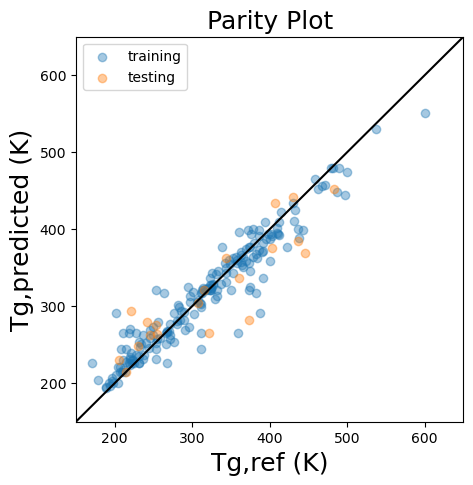

In [7]:
# Calculate the Tg predictions with the trained model
test_p = np.squeeze(single_model.predict(test_prints))
train_p = np.squeeze(single_model.predict(train_prints))

# Compute and print summary statistics                                                                                                                                                                                                 
ae = np.absolute(test_p-test_data["TG_ref"])
print('Summary test statistics for Tg,ref single task model:\n')
print('Mean AE:   {:< 4.2f}'.format(np.mean(ae)))
print('Mean %AE:  {:< 4.2f}'.format(np.mean(ae/test_data["TG_ref"]*100.0)))
print('StdAE:     {:< 4.2f}'.format(np.std(ae)))
print('Median AE: {:< 4.2f}'.format(np.median(ae)))

# Parity plot of ref vs predicted Tg in training data and testing data
plt.figure(figsize=(5,5))
plt.plot([150,650],[150,650],color="k")
plt.scatter(train_data["TG_ref"],train_p,alpha=0.4,label="training")
plt.scatter(test_data["TG_ref"],test_p,alpha=0.4,label="testing")
plt.xlim(150,650)
plt.ylim(150,650)
plt.xlabel("Tg,ref (K)",size=18)
plt.ylabel("Tg,predicted (K)",size=18)
plt.title("Parity Plot",size=18)
plt.legend()
plt.show()

The model has managed to linearize the training data, but there is still a large variance in the test set predictions. All in all it has perhaps done surprisingly well, considering that we've given it a generic fingerprint feature and hardly any data with which to learn the fingerprint --> `TG_ref` mapping. 

### Difference Model
As our transfer learning example we will train a random forest model to predict the difference between `TG_ref` and `TG_model`. The idea is that we have a model that already captures a lot of the physics of Tg and is cheap to calculate (i.e., we can also calculate it for any new polymers that aren't in the training set). Learning the difference between the real Tg and the model Tg should be easier than trying to learn the real Tg from scratch. 

Again, I have already performed a hyperparameter optimization outside of this notebook. Here we will just train the model with the hyperparameters I optimized from cross-validation on the training data. 

In [8]:
# Train a random forest model to predict the Tg difference (Tg_ref-Tg_model)
# Note: setting the random seed for reproducibility
diff_model = RandomForestRegressor(max_depth=10,random_state=0,n_estimators=10)
diff_model.fit(train_prints,train_data["TG_ref"]-train_data["TG_model"])

RandomForestRegressor(max_depth=10, n_estimators=10, random_state=0)

Summary test statistics for difference model:

Mean AE:    14.45
Mean %AE:   4.50
StdAE:      8.86
Median AE:  14.59


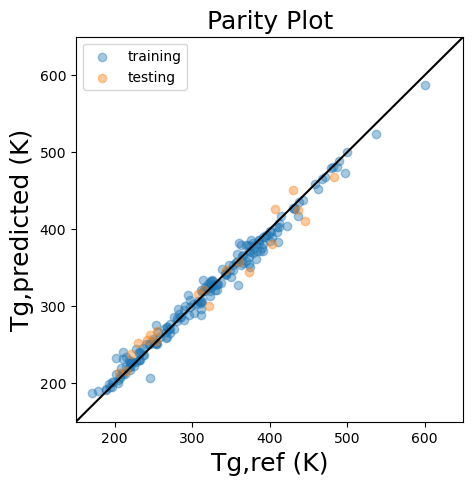

In [9]:
# Calculate the difference predictions with the trained model
# NOTE: Actual Tg_ref predictions are the difference plus TG_model values
test_dp = np.squeeze(diff_model.predict(test_prints))
test_p = test_dp + test_data["TG_model"]
train_dp = np.squeeze(diff_model.predict(train_prints))
train_p = train_dp + train_data["TG_model"]

# Compute and print summary statistics                                                                                                                                                                                                 
ae = np.absolute(test_p-test_data["TG_ref"])
print('Summary test statistics for difference model:\n')
print('Mean AE:   {:< 4.2f}'.format(np.mean(ae)))
print('Mean %AE:  {:< 4.2f}'.format(np.mean(ae/test_data["TG_ref"]*100.0)))
print('StdAE:     {:< 4.2f}'.format(np.std(ae)))
print('Median AE: {:< 4.2f}'.format(np.median(ae)))

# Parity plot of ref vs predicted Tg in training data and testing data
plt.figure(figsize=(5,5))
plt.plot([150,650],[150,650],color="k")
plt.scatter(train_data["TG_ref"],train_p,alpha=0.4,label="training")
plt.scatter(test_data["TG_ref"],test_p,alpha=0.4,label="testing")
plt.xlim(150,650)
plt.ylim(150,650)
plt.xlabel("Tg,ref (K)",size=18)
plt.ylabel("Tg,predicted (K)",size=18)
plt.title("Parity Plot",size=18)
plt.legend()
plt.show()

The difference model has performed strikingly better that the `TG_ref` only model. Looking at the original parity plot it is clear that the difference between `TG_ref` and `TG_model` has a much simpler relationship than the relationship between `TG_ref` and the `fingerprint`. By only focusing on learning the difference, we have transfered information from our empirical model into the original learning task (`fingerprint` --> `TG_ref`). I'll stress again, this example relied on us already having a cheap empirical model for Tg (`TG_model`). The circumstances when this will be true are common, but still just a subset of the circumstances when transfer learning would be useful. 